<a href="https://colab.research.google.com/github/UygarUsta/Codes/blob/main/Detection_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if not os.path.exists('open-images-bus-trucks'):
    !pip install -q torch_snippets torchsummary
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !git clone https://github.com/facebookresearch/detr.git

%cd /content/detr

     |████████████████████████████████| 43 kB 681 kB/s 
     |████████████████████████████████| 57 kB 4.3 MB/s 
     |████████████████████████████████| 212 kB 30.9 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 10.1 MB 41.2 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 
Cloning into 'detr'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 254 (delta 0), reused 2 (delta 0), pack-reused 250
Receiving objects: 100% (254/254), 12.85 MiB | 23.37 MiB/s, done.
Resolving deltas: 100% (135/135), done.
/content/detr


In [2]:
%cd ../open-images-bus-trucks/annotations
!cp mini_open_images_train_coco_format.json instances_train2017.json
!cp mini_open_images_val_coco_format.json instances_val2017.json
%cd ..
!ln -s images/ train2017
!ln -s images/ val2017
%cd ../detr

/content/open-images-bus-trucks/annotations
/content/open-images-bus-trucks
/content/detr


In [3]:
CLASSES = ['', 'BUS','TRUCK']

In [6]:
from torch_snippets import *
if not os.path.exists('detr-r50-e632da11.pth'):
    !wget https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
    checkpoint = torch.load("detr-r50-e632da11.pth", map_location='cpu')
    #del checkpoint["model"]["class_embed.weight"]
    #del checkpoint["model"]["class_embed.bias"]
    torch.save(checkpoint,"detr-r50_no-class-head.pth")

--2021-10-18 09:33:20--  https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166618694 (159M) [application/octet-stream]
Saving to: ‘detr-r50-e632da11.pth’

detr-r50-e632da11.p 100%[===================>] 158.90M  30.4MB/s    in 5.6s    

2021-10-18 09:33:26 (28.3 MB/s) - ‘detr-r50-e632da11.pth’ saved [166618694/166618694]



In [7]:
!python main.py --coco_path ../open-images-bus-trucks/ \
  --epochs 10 --lr=1e-4 --batch_size=2 --num_workers=4\
  --output_dir="outputs" --resume="detr-r50_no-class-head.pth"

Not using distributed mode
git:
  sha: b9048ebe86561594f1472139ec42327f00aba699, status: clean, branch: main

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='../open-images-bus-trucks/', dataset_file='coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=10, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=4, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of params: 41302368
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
lo

In [8]:
from main import get_args_parser, argparse, build_model
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args, _ = parser.parse_known_args()

model, _, _ = build_model(args)
model.load_state_dict(torch.load("outputs/checkpoint.pth")['model']);

In [14]:
from time import time

In [33]:
from PIL import Image, ImageDraw, ImageFont

# standard PyTorch mean-std input image normalization
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
          
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):

  x_c, y_c, w, h = x.unbind(1)
  b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
      (x_c + 0.5 * w), (y_c + 0.5 * h)]
  return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):

  img_w, img_h = size
  b = box_cxcywh_to_xyxy(out_bbox)
  b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
  return b
    
def detect(im, model, transform):

  img = transform(im).unsqueeze(0)
  assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'
  f = time()
  outputs = model(img)
  s = time()
  print("FPS:",1/ (s-f))
    # keep only predictions with 0.7+ confidence
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.7
    # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  return probas[keep], bboxes_scaled

def plot_results(pil_img, prob, boxes):
  plt.figure(figsize=(16,10))
  plt.imshow(pil_img)
  ax = plt.gca()
  for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
    cl = p.argmax()
    text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
    ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
  plt.axis('off')
  plt.show()

2021-10-18 10:24:27.848 | INFO     | torch_snippets.paths:inner:24 - 15225 files found at ../open-images-bus-trucks/images/*


FPS: 0.3565451426625497


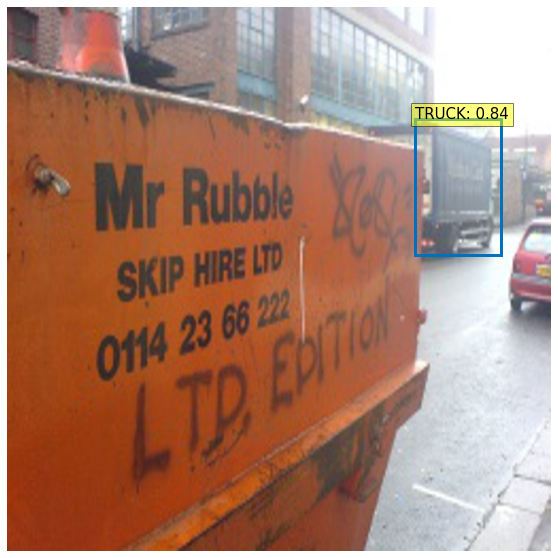

2021-10-18 10:24:31.229 | INFO     | torch_snippets.paths:inner:24 - 15225 files found at ../open-images-bus-trucks/images/*


FPS: 0.36021919045874806


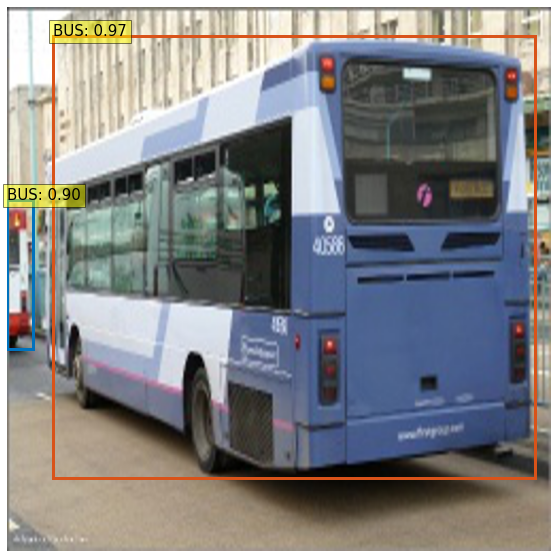

2021-10-18 10:24:34.614 | INFO     | torch_snippets.paths:inner:24 - 15225 files found at ../open-images-bus-trucks/images/*


FPS: 0.3612982363652965


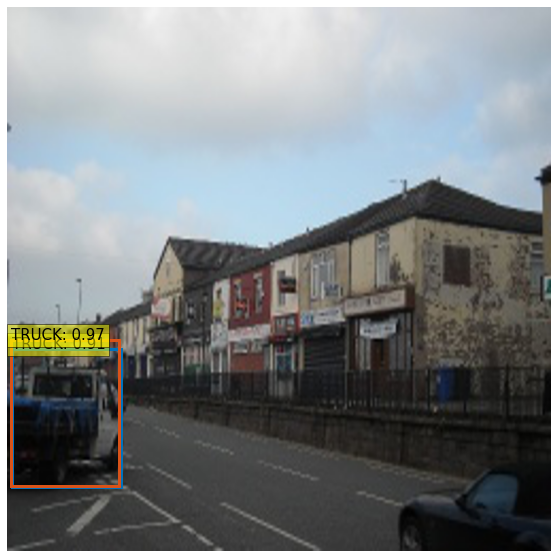

2021-10-18 10:24:38.060 | INFO     | torch_snippets.paths:inner:24 - 15225 files found at ../open-images-bus-trucks/images/*


FPS: 0.3608411618174443


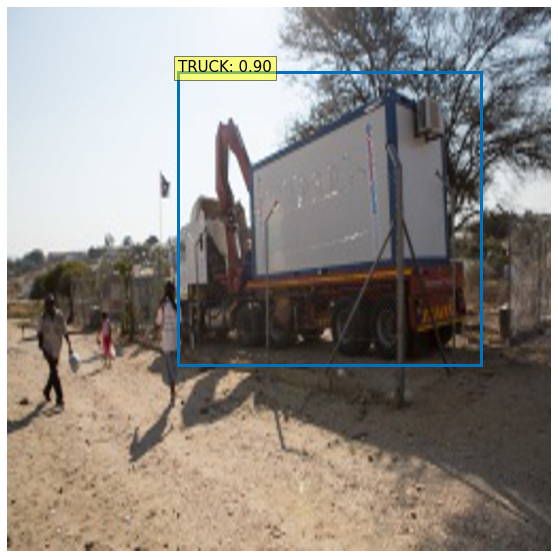

2021-10-18 10:24:41.409 | INFO     | torch_snippets.paths:inner:24 - 15225 files found at ../open-images-bus-trucks/images/*


FPS: 0.3632161926219113


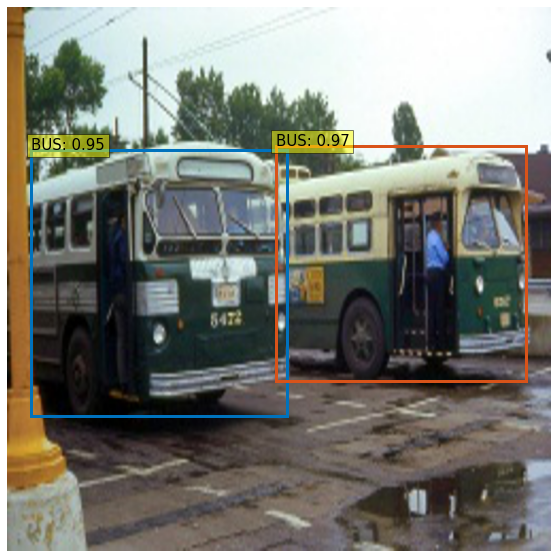

2021-10-18 10:24:44.821 | INFO     | torch_snippets.paths:inner:24 - 15225 files found at ../open-images-bus-trucks/images/*


FPS: 0.3599015036253973


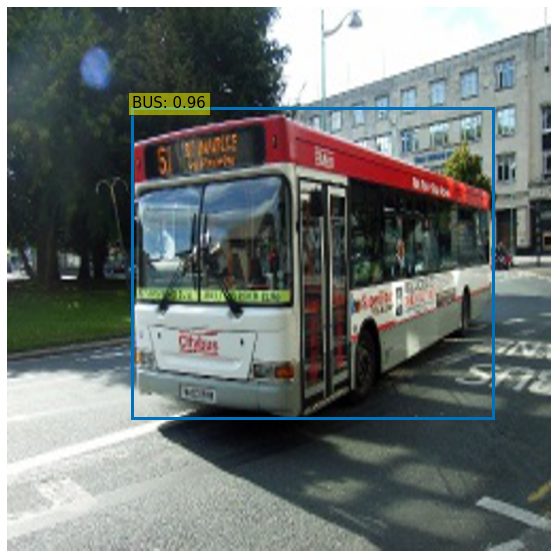

2021-10-18 10:24:48.345 | INFO     | torch_snippets.paths:inner:24 - 15225 files found at ../open-images-bus-trucks/images/*


FPS: 0.3632325492357038


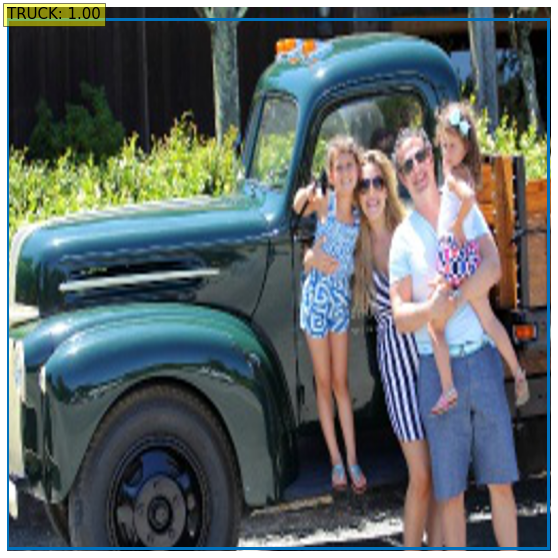

In [34]:
for _ in range(7):
    image = Image.open(choose(Glob('../open-images-bus-trucks/images/*'))).resize((800,800)).convert('RGB')
    scores, boxes = detect(image, model, transform)
    plot_results(image, scores, boxes)

In [11]:
!wget https://ichef.bbci.co.uk/news/976/cpsprodpb/13E79/production/_106992518_youngpassengersboardingbus-2.jpg

--2021-10-18 10:14:07--  https://ichef.bbci.co.uk/news/976/cpsprodpb/13E79/production/_106992518_youngpassengersboardingbus-2.jpg
Resolving ichef.bbci.co.uk (ichef.bbci.co.uk)... 72.247.62.242, 2600:1407:a800:1a3::f33, 2600:1407:a800:19a::f33, ...
Connecting to ichef.bbci.co.uk (ichef.bbci.co.uk)|72.247.62.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99764 (97K) [image/jpeg]
Saving to: ‘_106992518_youngpassengersboardingbus-2.jpg’

_106992518_youngpas 100%[===================>]  97.43K  --.-KB/s    in 0.02s   

2021-10-18 10:14:07 (4.02 MB/s) - ‘_106992518_youngpassengersboardingbus-2.jpg’ saved [99764/99764]



FPS: 3.487084837102421


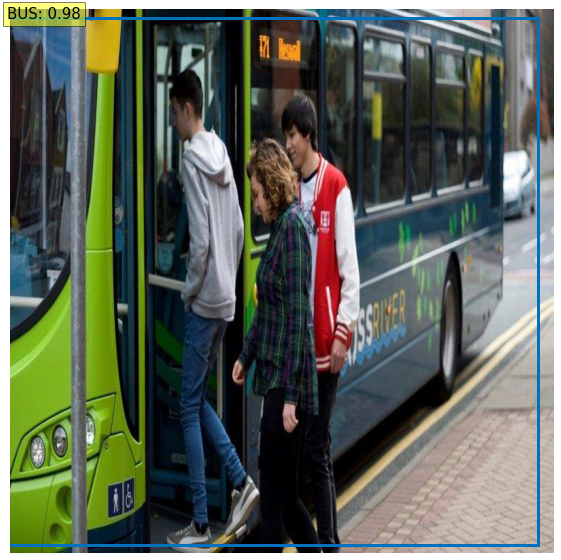

In [24]:
image = Image.open("/content/detr/bus.jpg").resize((800,800)).convert('RGB')
scores, boxes = detect(image, model, transform)
plot_results(image, scores, boxes)